In [1]:
from IPython.display import clear_output

In [2]:
import os

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

In [3]:
curr_path = os.path.abspath(os.getcwd())
data_path = os.path.join(curr_path, "plates")
data_path

'/home/glucas11/projects/repos/random-things-i-do/machine_learning/kaggle_competitions/Cleaned-vs-Dirty-V2/plates'

In [4]:
import shutil

if not os.path.isdir(data_path):
    !unzip {curr_path}/platesv2.zip -d {curr_path}/platesv2/
    !unzip {curr_path}/platesv2/plates.zip -d {curr_path}/tmp_plates/
    !mv {curr_path}/tmp_plates/plates/ {curr_path}/plates/
    !find {curr_path}/plates -name '.DS_Store' -type f -delete
    !rm -r {curr_path}/platesv2/
    !rm -r {curr_path}/tmp_plates
clear_output()

In [5]:
import os, random

def create_val_dataset(val_size=0.3):
    random.seed("happy :)")

    train_path = os.path.join(data_path, "train")
    val_path = os.path.join(data_path, "val")
    try:
        os.mkdir(val_path)
    except FileExistsError:
        print("val already exist")
        return
    
    classes_name = os.listdir(train_path)
    for class_name in classes_name:
        class_path = os.path.join(train_path, class_name)
        images_filename = os.listdir(class_path)
        sample_size = int(val_size * len(images_filename))
        selected_val_images = random.sample(images_filename, sample_size)
        
        new_class_path = os.path.join(val_path, class_name)
        os.mkdir(new_class_path)
        [shutil.move(os.path.join(class_path, image_filename),new_class_path) for image_filename in selected_val_images]

create_val_dataset()

val already exist


In [6]:
def get_transfer_learning_model(classifier_dropout, image_net):
    model = models.resnet152(weights=image_net)

    for param in model.parameters():
        param.requires_grad = True

    model.fc = nn.Sequential(
        nn.Dropout(classifier_dropout, inplace=True),
        nn.Linear(model.fc.in_features, 2),
    )
    
    return model

In [7]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight                           

In [8]:
import torch.utils
from torch.utils.data import DataLoader, Dataset

class AugmentedDataset(Dataset):
    def __init__(self, dataset, n_augmented_times_dataset, n_batch_size, transform=None):
        self.dataset = dataset
        self.n_augmented_times_dataset = n_augmented_times_dataset
        self.n_batch_size = n_batch_size
        self.transform = transform

    def __len__(self):
        # Return the number of batches times the batch size
        return len(self.dataset) * self.n_augmented_times_dataset

    def __getitem__(self, idx):
        # Get the original image and label
        img, label = self.dataset[idx % len(self.dataset)]

        # if random.random() > 0.9:
        #     img2, label2 = self.dataset[idx % len(self.dataset)]
        #     if label2 == label:
                
        
        # Apply transformations
        if self.transform:
            img = self.transform(img)
        
        return img, label
    
target_transforms = transforms.Compose([
    lambda x:torch.tensor(x), # or just torch.tensor
    lambda x:F.one_hot(x,2),
])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255),
        transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET),
        #transforms.RandomResizedCrop(232, scale=(0.5, 1), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ColorJitter(hue=(-0.5,0.5)),
        transforms.RandomEqualize(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.RandomAutocontrast(p=0.05),
        transforms.RandomAdjustSharpness(p=0.05, sharpness_factor=2),
        transforms.RandomSolarize(p=0.05, threshold=192.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
        transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET),
        #transforms.RandomResizedCrop(232, scale=(0.5, 1), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ColorJitter(hue=(-0.5,0.5)),
        # transforms.RandomEqualize(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        # transforms.RandomErasing(p=0.2, scale=(0.02, 0.5)),
    ]),
    'test': transforms.Compose([
        transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = data_path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), target_transform=target_transforms)
                  for x in ['train', 'val']}

augmented_dataset = {
    x: AugmentedDataset(image_datasets[x], 2, 50, transform=data_transforms[x])
    for x in ['train', 'val']
}

# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x], target_transform=target_transforms)
#                   for x in ['train', 'val']}

# weights = {x: make_weights_for_balanced_classes(image_datasets[x].imgs, len(image_datasets[x].classes)) for x in ['train', 'val']}
# weights = {x: torch.DoubleTensor(weights[x]) for x in ['train', 'val']}
# sampler = {x: torch.utils.data.sampler.WeightedRandomSampler(weights[x], len(weights[x])) for x in ['train', 'val']}
# dataloaders = {x: DataLoader(image_datasets[x], batch_size=50, num_workers=10, sampler=sampler[x])
#               for x in ['train', 'val']}

class_names = image_datasets['train'].classes


dataloaders = {x: DataLoader(augmented_dataset[x], batch_size=50, num_workers=10, shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names, device

(['cleaned', 'dirty'], device(type='cuda', index=0))

train


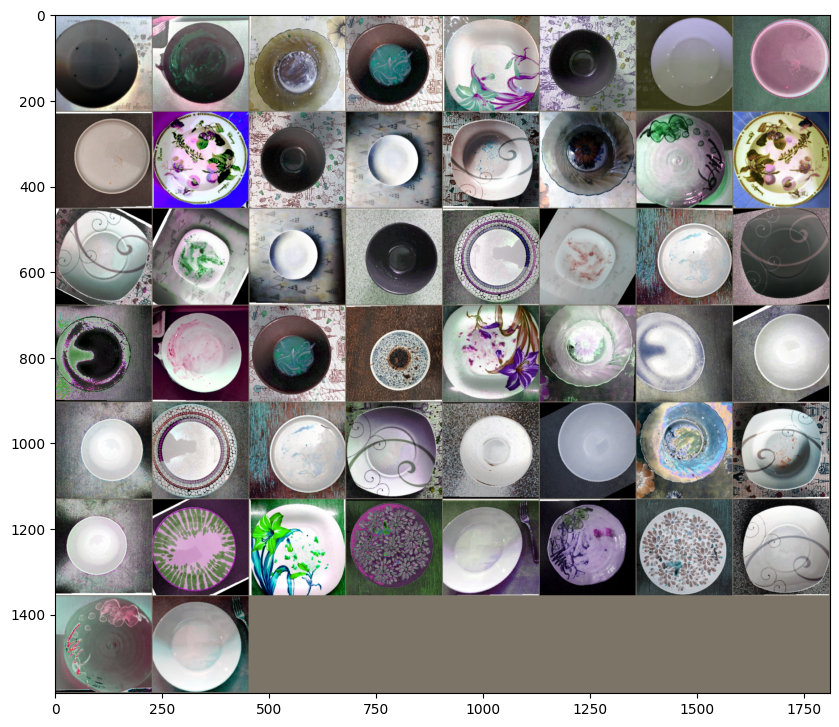

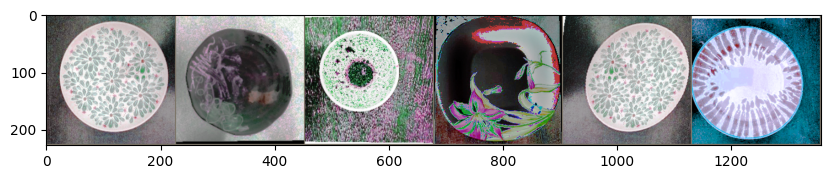

val


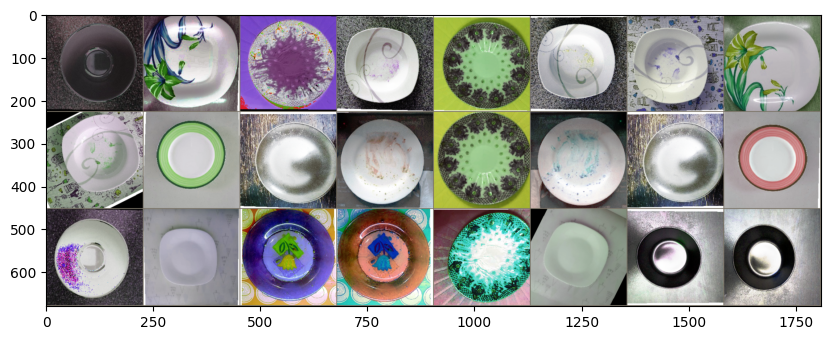

In [9]:
from torchvision.utils import make_grid
from matplotlib import pyplot as plt

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp,)
    #if title is not None:
    #    plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

phases = ['train','val']
for phase in phases:
    print(phase)
    for inputs, classes in dataloaders[phase]:

        # Get a batch of training data
        # inputs, classes = next(iter(dataloaders[phase]))
        classes = classes.max(axis=1)[1]
        
        # Make a grid from batch
        out = make_grid(inputs)

        imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_func(model, optimizer, exp_lr_scheduler, clip_value):
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    running_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(dataloaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target.float())

        total += output.size(0)
        running_loss += loss.item() * output.size(0)

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        # accuracy
        _, predicted = torch.max(output.data, 1)
        _, correct_class = torch.max(target.data, 1)
        
        correct += (predicted == correct_class).sum().item()
    
    exp_lr_scheduler.step()
    
    return {
        "mean_loss": running_loss / total,
        "mean_accuracy": correct / total,
    }

def test_func(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloaders['val']):
            
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            _, correct_class = torch.max(target.data, 1)
            total += target.size(0)
            correct += (predicted == correct_class).sum().item()

            # loss
            running_loss += F.cross_entropy(outputs, target.float()).item() * outputs.size(0)
    
    return {
        "mean_loss": running_loss / total,
        "mean_accuracy": correct / total,
    }

In [11]:
import os
import tempfile

from ray.train import Checkpoint

def train_dishs(config, max_epochs=30, tunning=True):
    
    # Data Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_transfer_learning_model(config['classifier_dropout'], config['image_net'])
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(),
        lr=config["lr"],
        momentum=config["momentum"],
        weight_decay=config['weight_decay'],
        nesterov=config['nesterov']
    )
    
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=config['lr_scheduler_gamma'])
    for i in range(max_epochs):
        train_log = train_func(model, optimizer, exp_lr_scheduler, config['clip_value'])
        val_log = test_func(model)

        if tunning:
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                checkpoint = None
                if (i + 1) % max_epochs == 0 and (val_log["mean_loss"] < 0.4):
                    # This saves the model to the trial directory
                    torch.save(
                        model.state_dict(),
                        os.path.join(temp_checkpoint_dir, "model.pth")
                    )
                    checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

                # Send the current training result back to Tune
                train.report(
                    {
                        "train_mean_loss": train_log["mean_loss"],
                        "train_mean_accuracy": train_log["mean_accuracy"],
                        "val_mean_loss": val_log["mean_loss"],
                        "val_mean_accuracy": val_log["mean_accuracy"],
                    },
                    checkpoint=checkpoint
                )
        else:
            print("-"*10, f"epoch: {i+1}/{max_epochs}","-"*10)
            print(f"train: {train_log}\nval: {val_log}")
    if not tunning:
        return {
            "model": model,
            "log": {
                "train": train_log,
                "val": val_log,
            },
        }

In [12]:
import json

try:
    with open("best_result.json", "r") as f:
        curr_best_params = [json.load(f)]
except:
    curr_best_params = None

curr_best_params

[{'lr': 0.09993900880833266,
  'momentum': 0.5682063652493501,
  'classifier_dropout': 0.4682230537634,
  'weight_decay': 3.876038751058159e-06,
  'clip_value': 5,
  'lr_scheduler_gamma': 0.9325346202269802,
  'image_net': 'IMAGENET1K_V2',
  'nesterov': False}]

In [13]:
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler


space = {
    "lr": hp.loguniform("lr", -5, -1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
    "classifier_dropout": hp.uniform("classifier_dropout", 0.3, 0.7),
    "weight_decay": hp.loguniform("weight_decay", -6, -2),
    "clip_value": hp.randint("clip_value", 1, 5+1),
    "lr_scheduler_gamma": hp.uniform("lr_scheduler_gamma", 0.5, 1.0),
    "image_net": hp.choice("image_net", ["IMAGENET1K_V1", "IMAGENET1K_V2"]),
}

metric = "val_mean_loss"
mode = "min"

hyperopt_search = HyperOptSearch(
    space,
    metric=metric,
    mode=mode,
    points_to_evaluate = curr_best_params
)

asas_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric=metric,
    mode=mode,
    max_t=30,
    grace_period=1,
    reduction_factor=3,
    brackets=2
)

trainable_with_resources = tune.with_resources(train_dishs, {"cpu": 12, "gpu": 1})

tuner = tune.Tuner(
    trainable_with_resources,
    tune_config=tune.TuneConfig(
        num_samples=40,
        search_alg=hyperopt_search,
        scheduler=asas_scheduler
    ),
)
results = tuner.fit()

2024-06-19 12:19:16,610	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/glucas11/ray_results/train_dishs_2024-06-19_12-13-59' in 0.0099s.
2024-06-19 12:19:16,623	INFO tune.py:1041 -- Total run time: 314.36 seconds (314.31 seconds for the tuning loop).


In [13]:
from ray.tune.search.optuna import OptunaSearch

from ray.tune.schedulers import ASHAScheduler


config = {
    "lr": tune.loguniform(1e-5, 1e-0),
    "momentum": tune.uniform(0.1, 0.9),
    "classifier_dropout": tune.uniform(0.3, 0.7),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "clip_value": tune.randint(1, 5+1),
    "lr_scheduler_gamma": tune.uniform(0.5, 1.0),
    "image_net": tune.choice(["IMAGENET1K_V1", "IMAGENET1K_V2"]),
    "nesterov": tune.choice([True, False])
}

metric = "val_mean_loss"
mode = "min"


optuna_search = OptunaSearch(
    metric=metric,
    mode=mode)

asas_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric=metric,
    mode=mode,
    max_t=30,
    grace_period=1,
    reduction_factor=3,
    brackets=2
)

trainable_with_resources = tune.with_resources(train_dishs, {"cpu": 12, "gpu": 1})

tuner = tune.Tuner(
    trainable_with_resources,
    tune_config=tune.TuneConfig(
        num_samples=40,
        search_alg=optuna_search,
        scheduler=asas_scheduler
    ),
    param_space=config,
)
results = tuner.fit()

(train_dishs pid=477961) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/glucas11/ray_results/train_dishs_2024-06-20_11-17-57/train_dishs_59926084_19_classifier_dropout=0.3078,clip_value=4,image_net=IMAGENET1K_V2,lr=0.1638,lr_scheduler_gamma=0.5824,momentu_2024-06-20_11-23-00/checkpoint_000000)
(train_dishs pid=496005) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/glucas11/ray_results/train_dishs_2024-06-20_11-17-57/train_dishs_3d5451fd_23_classifier_dropout=0.3490,clip_value=4,image_net=IMAGENET1K_V2,lr=0.2101,lr_scheduler_gamma=0.5745,momentu_2024-06-20_11-24-52/checkpoint_000000)
(train_dishs pid=510910) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/glucas11/ray_results/train_dishs_2024-06-20_11-17-57/train_dishs_a6daf822_28_classifier_dropout=0.4288,clip_value=3,image_net=IMAGENET1K_V1,lr=0.0456,lr_scheduler_gamma=0.6619,momentu_2024-06-20_11-26-26/checkpoint_000000)
(train_dishs pid=522989) Che

In [14]:
best_result = results.get_best_result("val_mean_accuracy", mode="max")
best_result.metrics

{'train_mean_loss': 0.07460563962480851,
 'train_mean_accuracy': 0.9821428571428571,
 'val_mean_loss': 0.1821160763502121,
 'val_mean_accuracy': 0.9583333333333334,
 'timestamp': 1718897330,
 'checkpoint_dir_name': 'checkpoint_000000',
 'should_checkpoint': True,
 'done': True,
 'training_iteration': 30,
 'trial_id': 'd1abd6ab',
 'date': '2024-06-20_11-28-50',
 'time_this_iter_s': 2.3843445777893066,
 'time_total_s': 62.89986968040466,
 'pid': 522989,
 'hostname': 'DESKTOP-GF0BL1G',
 'node_ip': '172.18.58.174',
 'config': {'lr': 0.02766468968325887,
  'momentum': 0.7962810811164651,
  'classifier_dropout': 0.3714263433382429,
  'weight_decay': 2.776619125422902e-06,
  'clip_value': 2,
  'lr_scheduler_gamma': 0.7207518118121516,
  'image_net': 'IMAGENET1K_V1',
  'nesterov': True},
 'time_since_restore': 62.89986968040466,
 'iterations_since_restore': 30,
 'experiment_tag': '30_classifier_dropout=0.3714,clip_value=2,image_net=IMAGENET1K_V1,lr=0.0277,lr_scheduler_gamma=0.7208,momentum=0.7

In [15]:
import json

with open("best_result.json", 'w') as f:
    json.dump(best_result.config, f, default=str)

In [18]:
best_result = results.get_best_result("val_mean_loss", mode="min")
with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))

model = get_transfer_learning_model(best_result.config['classifier_dropout'], best_result.config['image_net']).to(device)
model.load_state_dict(state_dict)
to_csv(model)

In [17]:
from PIL import Image
import pandas as pd

def to_csv(model, batch_size=10):
    model.eval()
    PATH_TEST = os.path.join(data_path, "test")
    test_file_names = os.listdir(PATH_TEST)
    test_file_names.sort()

    submission_csv = {
        "id": [],
        "label": []
    }

    for file_name in test_file_names:
        id = file_name.split(".")[0]
        test_input = Image.open(os.path.join(PATH_TEST, file_name))
        test_input = data_transforms['test'](test_input).to(device).unsqueeze(0)
        with torch.no_grad():
            pred_test_label = model(test_input).max(1).indices.item()
            pred_test_label = class_names[pred_test_label]
        submission_csv['id'].append(id)
        submission_csv['label'].append(pred_test_label)

    submission_csv = pd.DataFrame(submission_csv).set_index("id")
    submission_csv.to_csv("submission.csv")

In [19]:
import json

with open("best_result.json", "r") as f:
    best_config_loaded = json.load(f)

best_config_loaded

{'lr': 0.02766468968325887,
 'momentum': 0.7962810811164651,
 'classifier_dropout': 0.3714263433382429,
 'weight_decay': 2.776619125422902e-06,
 'clip_value': 2,
 'lr_scheduler_gamma': 0.7207518118121516,
 'image_net': 'IMAGENET1K_V1',
 'nesterov': True}

In [16]:
best_config_train_model = train_dishs(best_config_loaded, max_epochs=30, tunning=False)

KeyError: 'nesterov'

In [17]:
new_model = best_config_train_model['model']

In [46]:
def pseudo_label_test_dataset(model):
    model.eval()
    PATH_TEST = os.path.join(data_path, "test")
    test_file_names = os.listdir(PATH_TEST)
    test_file_names.sort()

    imgs_path = []
    imgs_pred_label = []
    imgs_pred_prob = []

    for i, file_name in enumerate(test_file_names):
        img_path = os.path.join(PATH_TEST, file_name)
        img = Image.open(img_path)
        test_input = data_transforms["test"](img).to(device).unsqueeze(0)
        with torch.no_grad():
            output = model(test_input)
            pred_labels_indices = output.max(1).indices.item()
            pred_label = class_names[pred_labels_indices]
            prob, indice = F.softmax(output, dim=1).max(1)
            if prob > 0.95 and pred_label == "dirty":
                print(prob, pred_label)
                dest_path = data_path + os.sep + "train" + os.sep + pred_label + os.sep + f"from_test_{int(prob.item() * 100)}_____" + file_name
                !cp {img_path} {dest_path}

            elif prob > 0.9 and pred_label == "cleaned":
                print(prob, pred_label)
                dest_path = data_path + os.sep + "train" + os.sep + pred_label + os.sep + f"from_test_{int(prob.item() * 100)}_____" + file_name
                !cp {img_path} {dest_path}

pseudo_label_test_dataset(new_model)

tensor([0.9631], device='cuda:0') dirty
tensor([0.9817], device='cuda:0') dirty
tensor([0.9802], device='cuda:0') dirty
tensor([0.9887], device='cuda:0') dirty
tensor([0.9872], device='cuda:0') dirty
tensor([0.9562], device='cuda:0') dirty
tensor([0.9760], device='cuda:0') dirty
tensor([0.9524], device='cuda:0') dirty
tensor([0.9655], device='cuda:0') dirty
tensor([0.9905], device='cuda:0') dirty
tensor([0.9763], device='cuda:0') dirty
tensor([0.9606], device='cuda:0') dirty
tensor([0.9695], device='cuda:0') dirty
tensor([0.9764], device='cuda:0') dirty
tensor([0.9796], device='cuda:0') dirty
tensor([0.9573], device='cuda:0') dirty
tensor([0.9846], device='cuda:0') dirty
tensor([0.9740], device='cuda:0') dirty
tensor([0.9573], device='cuda:0') dirty
tensor([0.9560], device='cuda:0') dirty
tensor([0.9783], device='cuda:0') dirty
tensor([0.9642], device='cuda:0') dirty
tensor([0.9621], device='cuda:0') dirty
tensor([0.9932], device='cuda:0') dirty
tensor([0.9573], device='cuda:0') dirty


In [22]:
# phases = ['train','val']
# for phase in phases:
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     for inputs, labels in dataloaders[phase]:
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         #calculate val loss
#         outputs = new_model(inputs)
#         loss = F.cross_entropy(outputs, labels.float()).item()
#         print(loss)

#         # Get a batch of training data
#         classes = labels.max(axis=1)[1]
#         pred_classes = outputs.max(axis=1)[1]
#         print([class_names[i] for i in classes])
#         print(pred_classes == classes)
        
#         # Make a grid from batch
#         out = make_grid(inputs)

#         imshow(out.cpu(), title=[class_names[x] for x in classes])

In [18]:
to_csv(new_model)

In [20]:
df = results.get_dataframe()
df.head()

,train_mean_loss,train_mean_accuracy,val_mean_loss,val_mean_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,...,config/lr,config/momentum,config/classifier_dropout,config/weight_decay,config/clip_value,config/lr_scheduler_gamma,config/image_net,config/nesterov,logdir,should_checkpoint
0,0.728962,0.392857,0.735604,0.458333,1718896742,None,True,30,4bdfb2cd,2024-06-20_11-19-02,...,0.000611,0.240841,0.460895,0.000185,2,0.558568,IMAGENET1K_V2,True,4bdfb2cd,NaN
1,0.757105,0.464286,1.011568,0.500000,1718896747,None,True,1,79cec086,2024-06-20_11-19-07,...,0.013525,0.701403,0.449617,0.000002,4,0.812711,IMAGENET1K_V1,False,79cec086,NaN
2,0.083276,0.982143,0.509810,0.708333,1718896812,None,True,30,9d96164e,2024-06-20_11-20-12,...,0.115564,0.666538,0.400581,0.000466,4,0.509967,IMAGENET1K_V2,True,9d96164e,NaN
3,0.662109,0.535714,0.681138,0.583333,1718896823,None,True,3,8f96048a,2024-06-20_11-20-23,...,0.013278,0.624271,0.672836,0.000002,4,0.815858,IMAGENET1K_V2,True,8f96048a,NaN
4,3.221120,0.392857,7.251188,0.500000,1718896828,None,True,1,8f51d834,2024-06-20_11-20-28,...,0.615722,0.254955,0.582367,0.005369,4,0.511231,IMAGENET1K_V1,True,8f51d834,NaN


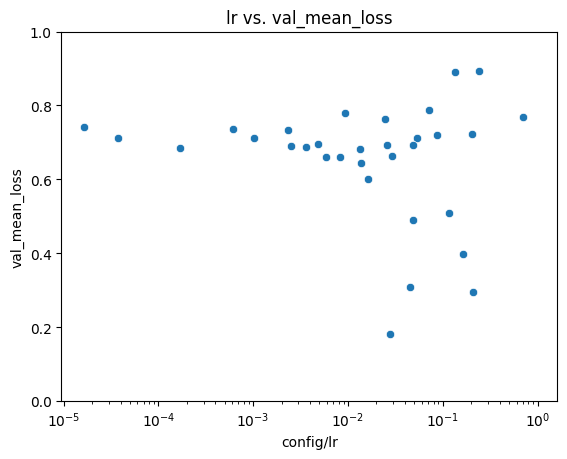

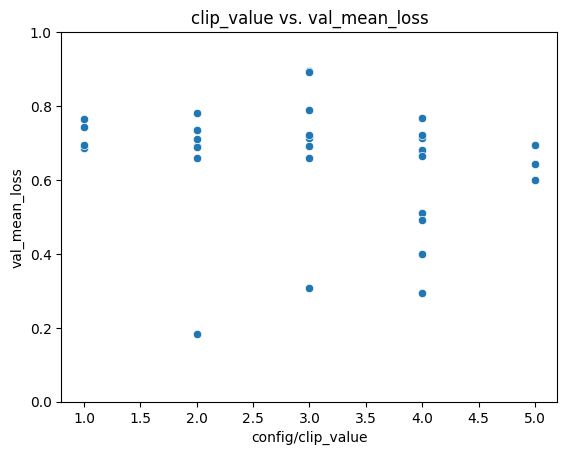

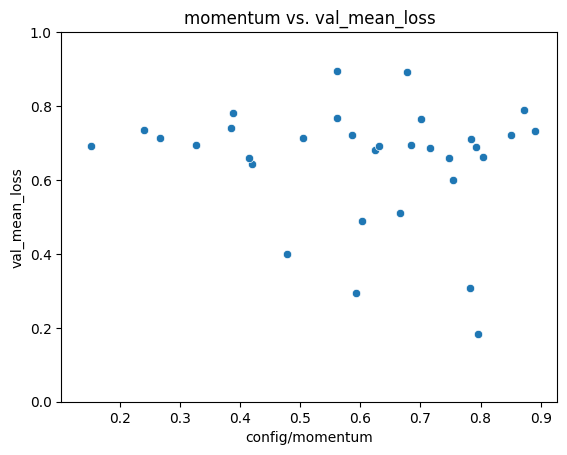

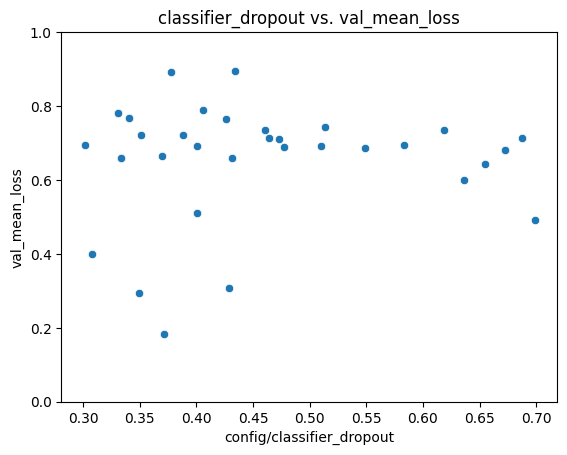

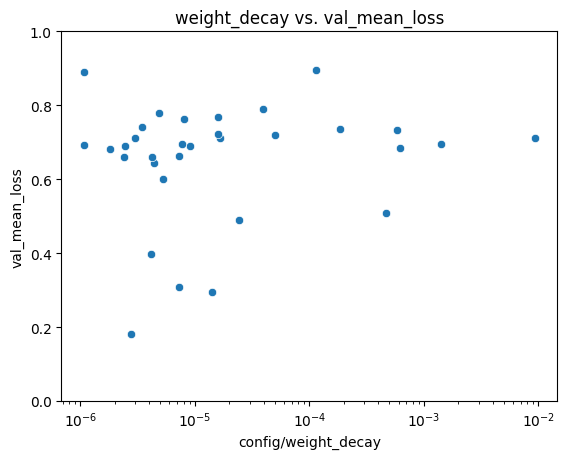

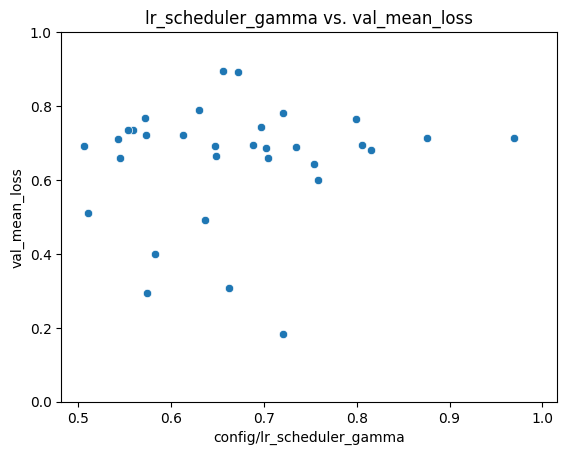

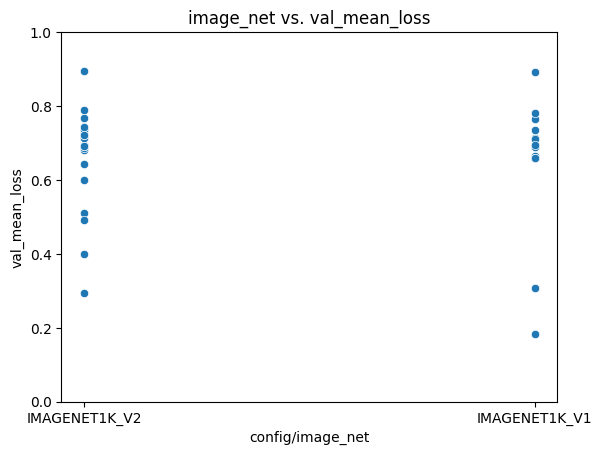

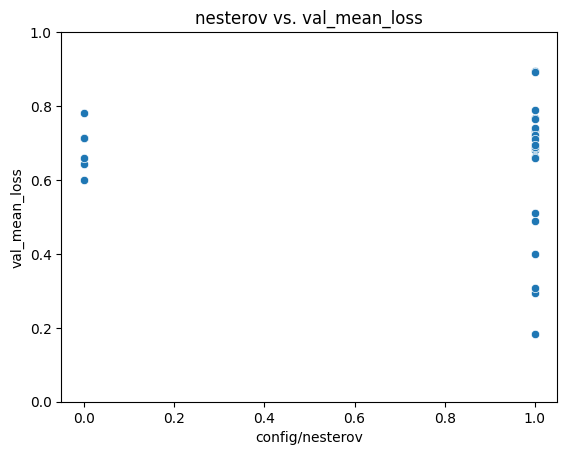

In [21]:
# Analyze the results
import seaborn as sns
import matplotlib.pyplot as plt

log_plots = ["lr", "weight_decay"]
def plot_scatter(data, x_param, y_param="val_mean_loss"):
    
    if x_param == "clip_value":
        data[f"config/{x_param}"] = np.array(data[f"config/{x_param}"], dtype=int)
    sns.scatterplot(data=data, x=f'config/{x_param}', y=y_param)
    plt.title(f'{x_param} vs. {y_param}')
    plt.ylim(0,1.0)
    #plt.yscale("log")
    if x_param in log_plots:
        plt.xscale("log")
    plt.show()

# Create scatter plots for each hyperparameter
plot_scatter(df, 'lr')
plot_scatter(df, 'clip_value')
plot_scatter(df, 'momentum')
plot_scatter(df, 'classifier_dropout')
plot_scatter(df, 'weight_decay')
plot_scatter(df, 'lr_scheduler_gamma')
plot_scatter(df, 'image_net')
plot_scatter(df, 'nesterov')

In [26]:
# !rm -r ./plates